# Day 15 Visualising amazon rivers

In [1]:
from pathlib import Path
import rasterio as rio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import folium
from folium import plugins

In [2]:
path = Path('../data/rivers_amazon_data/ndwi_test/')
image_path = path.joinpath('k_means_ndwi.tif')
output_tif = path.joinpath('rivers.tif')

In [3]:
with rio.open(image_path) as src:
    im = src.read()
    meta = src.meta

In [4]:
rivers = np.where(im>0, np.nan, im)

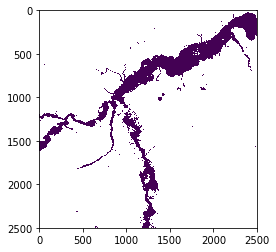

In [8]:
show(rivers);

In [6]:
meta.update({'dtype': 'float64'})

In [7]:
with rio.open(output_tif, 'w', **meta) as dst:
    dst.write(rivers)

### Visualise river on webmap using folium

source of code: https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/interactive-maps/

Reproject the raster dataset for folium webtiles in WGS84

In [9]:
# Create variables for destination coordinate system and the name of the projected raster
dst_crs = 'EPSG:4326' 
out_path = path.joinpath('reproj_rivers_full.tif')


# Use rasterio package as rio to open and project the raster
with rio.open(image_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
 

    # Use rasterio package as rio to write out the new projected raster
    # Code uses loop to account for multi-band rasters
    with rio.open(out_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
            source=rio.band(src, i),
            destination=rio.band(dst, i),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest) 

In [10]:
with rio.open(out_path) as src:
    boundary = src.bounds
    img = src.read()
    nodata = src.nodata

In [11]:
bounds = [boundary[1], boundary[0]], [boundary[3], boundary[2]]; 
bounds = list(bounds)

In [12]:
m = folium.Map(location = [-2.95322, -54.43651], 
                tiles = 'Stamen Terrain')
m.add_child(folium.raster_layers.ImageOverlay(img[0], 
                                              bounds = bounds, 
                                              opacity=.7)); m

### Polygonize and visualize

Now to create a polygon of rivers. Using gdal_polygonize.py I used the command line in the folder where the amazon river data exists.
```
gdal_polygonize.py k_means_ndwi.tif -f "ESRI Shapefile" rivers.shp
```
This process took about 10minutes. 

Tested on the rivers.tif but I recieved a square polygon. Weird. I can investigate further as this would save more time and RAM. 